In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5),(0.5))#eklendikten sonra -1 ile 1 arasına sabitlendi
#])

mnist_data = datasets.MNIST(root = '../data', train = True, download = True, transform = transform)

data_loder = DataLoader(mnist_data, batch_size = 64, shuffle = True, num_workers = 4, pin_memory = True) 

In [3]:
dataiter = iter(data_loder)
images, labels = dataiter.next()
print(images.min(), images.max())#0 ile 1 arası olduğundan sigmoid kullandık 

tensor(0.) tensor(1.)


### Linear Layer Autoencoder

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
             nn.Linear(28*28, 128),#N, 784 -> N, 128
             nn.ReLU(), 
             nn.Linear(128, 64),
             nn.ReLU(), 
             nn.Linear(64, 12),
             nn.ReLU(), 
             nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
             nn.Linear(3, 12),#N, 784 -> N, 128
             nn.ReLU(), 
             nn.Linear(12, 64),
             nn.ReLU(), 
             nn.Linear(64, 128),
             nn.ReLU(), 
             nn.Linear(128, 784),
             #nn.Tanh()
             nn.Sigmoid())
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [28]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [38]:
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loder:
        img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0422
Epoch:2, Loss:0.0349
Epoch:3, Loss:0.0418
Epoch:4, Loss:0.0358
Epoch:5, Loss:0.0381
Epoch:6, Loss:0.0335
Epoch:7, Loss:0.0334
Epoch:8, Loss:0.0388
Epoch:9, Loss:0.0334
Epoch:10, Loss:0.0319
Epoch:11, Loss:0.0395
Epoch:12, Loss:0.0360
Epoch:13, Loss:0.0348
Epoch:14, Loss:0.0347
Epoch:15, Loss:0.0332
Epoch:16, Loss:0.0302
Epoch:17, Loss:0.0332
Epoch:18, Loss:0.0318
Epoch:19, Loss:0.0379
Epoch:20, Loss:0.0334


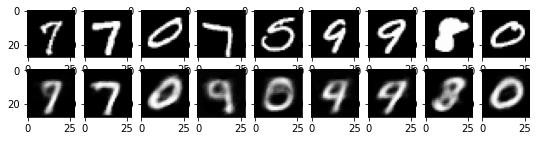

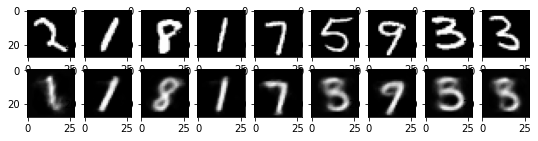

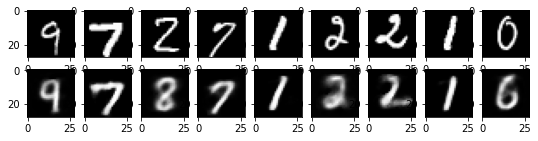

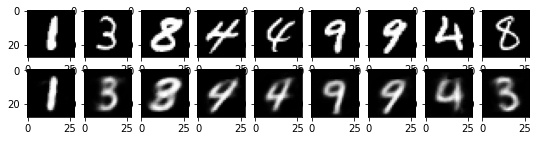

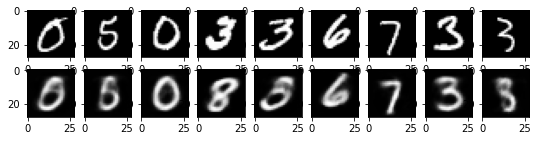

In [39]:
for k in range(0, num_epochs, 4):#her 4 epochta bir çizdiricek
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

### Convolutional Layer Autoencoder

In [4]:
class AutoencoderConv(nn.Module):
    def __init__(self):
        super(AutoencoderConv, self).__init__()
        self.encoder = nn.Sequential(
            #N, 1, 28, 28
             nn.Conv2d(1, 16, 3, stride = 2, padding = 1),# N, 16, 14, 14 
             nn.ReLU(), 
             nn.Conv2d(16, 32, 3, stride = 2, padding = 1),# N, 32, 7, 7 
             nn.ReLU(), 
             nn.Conv2d(32, 64, 3))# N, 64, 1, 1
        
        self.decoder = nn.Sequential(
             #N, 64, 1, 1 
             nn.ConvTranspose2d(64, 32, 3),# N, 32, 7, 7 
             nn.ReLU(), 
             nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),# N, 16, 13, 13 -(output_padding)> N, 16, 14, 14
             nn.ReLU(), 
             nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),# N, 1, 27, 27 -(output_padding)> N, 1, 28, 28
             #nn.Tanh()
             nn.Sigmoid())
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = AutoencoderConv()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [7]:
num_epochs = 5
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loder:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0015
Epoch:2, Loss:0.0016
Epoch:3, Loss:0.0014
Epoch:4, Loss:0.0011
Epoch:5, Loss:0.0009


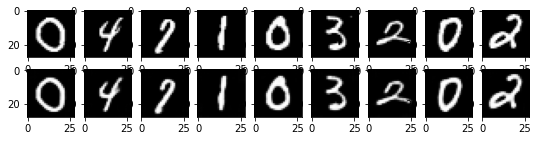

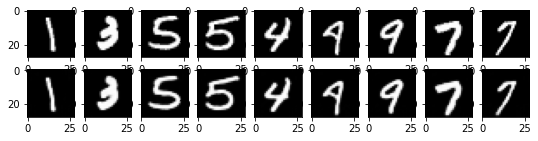

In [8]:
for k in range(0, num_epochs, 4):#her 4 epochta bir çizdiricek
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])